<a href="https://colab.research.google.com/github/dan-manolescu/data-structures-fun/blob/main/C14_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
from typing import List, Tuple
from collections import deque
import pandas as pd

Class to define an Edge between graph nodes, represented by the node "from" and "to" as well as a weight value.

In [105]:
class Edge:
    def __init__(self, to_node: int, from_node: int, weight: float):
        self.to_node = to_node
        self.from_node = from_node
        self.weight = weight

Class to define a Node in the graph. The node is represented by a name, a unique id (in our particular implementation it should be just the index of the node in the graph node list), as well as a list of edges that connect this node to others.

In [106]:
class Node:
    def __init__(self, id: int, name: str):
        self.name = name
        self.id = id
        self.edges = []

Class to define a Graph, represented as a number of nodes and a list of nodes. Current limitations of the implementation:
* the number of nodes should the same as the length of the nodes list.
* every node in the list must have as id the index of it's position in the graph nodes list.

The graph class exposed three methods:
* Dijkstras: returns the shortes path from a start node to every other node using the Dijkstras algorithm
* Prims: returns a set of edges that compose the minimum spanning tree for this graph
* Kahns: returns a list of topologically sorted nodes for the graph. Only works if the graph is a directed acyclic graph.

In [107]:
class Graph:
    def __init__(self):
        self.num_nodes = 0
        self.nodes = []

    def Dijkstras(self, from_node_index: int) -> List[tuple[str, float, float]]:
        '''
        Djikstra's algorithm finds the shortest path from any given starting
        node to all nodes in the graph. It will return a list where the index
        is the node id and the value is node name, the distance to that node
        and the index of the last node visited before.
        '''

        def min_distance_node(distance, unvisited):
            '''
            Utility function used to find out the node index in unvisited with
            the minimal distance.
            These could be replaced with a min-heap structure instead
            '''
            min_distance = float("inf")
            min_index = None
            for index in unvisited:
                if distance[index] < min_distance:
                    min_distance = distance[index]
                    min_index = index
            return min_index

        # Create a list of distances to each node.
        distance = [float("inf")] * self.num_nodes
        distance[from_node_index] = 0.0
        # Create a list of the last node visited before a given node
        last = [-1] * self.num_nodes
        # Create a set of unvisited nodes
        unvisited = set([node.id for node in self.nodes])

        # On each iteration choose the node with the min distance and remove it
        # from the unvisited set.
        while len(unvisited) != 0:
            next_index = min_distance_node(distance, unvisited)
            current = self.nodes[next_index]
            unvisited.remove(next_index)

            # Look at all the node neighbors and compute the distance to that
            # neighbor through the current node.
            for edge in current.edges:
                new_dist = distance[edge.from_node] + edge.weight
                if new_dist < distance[edge.to_node]:
                    # Update distance and last lists if the code has found a
                    # better path.
                    distance[edge.to_node] = new_dist
                    last[edge.to_node] = edge.from_node

        return zip([node.name for node in self.nodes], distance, last)

    def Prims(self) -> set:
        '''
        Prim's algorithm for finding the Minimum Spanning Tree.
        Returns a set of edges for the mst.
        '''

        def min_distance_node(distance, unvisited):
            '''
            Utility function to find the node index in unvisited with the
            minimal distance. Start with index 0 since initially all entries
            are "inf".
            '''
            min_distance = float('inf')
            min_index = 0
            for index in unvisited:
                if distance[index] < min_distance:
                    min_distance = distance[index]
                    min_index = index
            return min_index

        def find_edge(to_node, from_node):
            '''
            Utility function to find the edge between to_node and from_node.
            '''
            for edge in self.nodes[from_node].edges:
                if edge.to_node == to_node and edge.from_node == from_node:
                    return edge

        # List of distances to each node.
        distance = [float('inf')] * self.num_nodes
        # List of last node visited before a given node.
        last = [-1] * self.num_nodes
        # Set of unvisited nodes (initially all the graph nodes).
        unvisited = set([node.id for node in self.nodes])
        # Set of edges for the minimal spanning tree.
        mst_edges = set()

        # Process the unvisited nodes one at a time until the set is empty.
        while len(unvisited) != 0:
            # The node with the minimal distance to any of the visited nodes
            # is chosen (and then removed from unvisited set).
            next_id = min_distance_node(distance, unvisited)
            # Check if an incoming edge to the node exists, necessary since
            # the first node visited will not have an incoming edge.
            # Add it to the minimum spanning tree.
            if last[next_id] != -1:
                mst_edges.add(find_edge(last[next_id], next_id))
            unvisited.remove(next_id)

            current = self.nodes[next_id]
            # Iterate through all the node's neighbors, check if a neighbor is
            # unvisited and it's distance
            for edge in current.edges:
                if edge.to_node in unvisited:
                    if edge.weight < distance[edge.to_node]:
                        distance[edge.to_node] = edge.weight
                        last[edge.to_node] = current.id

        return mst_edges

    def Kahns(self) -> List[Node]:
        '''
        Kahn's algorithm for topological sorting a directed acyclic graph.
        The algorithm operates by finding the nodes with no incoming edges,
        removing them from the list then appending them to our sorted list,
        and then removing the outbound edges from that node. The algorithm
        repeats until we have added every node to the sorted list.
        '''
        # Create a list to hold the sorted list of nodes (the output).
        sorted = []
        # Create a list to store the count of incoming edges for each node.
        count = [0] * self.num_nodes
        # Create a stack of the next node to add to sorted.
        next = deque([])

        # Count the incoming edges and update the count list.
        for node in self.nodes:
            for edge in node.edges:
                count[edge.to_node] += 1

        # Find the initial nodes without incoming edges to add them to the stack.
        for node in self.nodes:
            if count[node.id] == 0:
                next.append(node)

        # Iteratively process the remaining nodes without incoming connections.
        while next:
            # On each iteration pop a node off the stack and add it to the sorted.
            current = next.pop()
            sorted.append(current)
            # Iterate over the node edges and remove the incoming edge for each
            # neighbor (by reducing the count value).
            for edge in current.edges:
                count[edge.to_node] -= 1
                # Any neighbor with an incoming count of zero is pushed to next.
                if count[edge.to_node] == 0:
                    next.append(self.nodes[edge.to_node])

        return sorted

Utility function to draw a graph. It uses either a Graph or a Digraph graphviz structure to depict the graph based if the graph is directed or not.
If a minimum spanning tree set of edges is supplied these will be drawn with red.

**Note:** the graph should be drawn in directed mode in case of using the minimum spanning tree as right now there is a limitation in the way undirected graphs are drawn and some edges from the MSP might be missed.

In [108]:
import graphviz

def visualize_graph(graph: Graph, directed: bool=False, min_span_tree: set=None) -> graphviz.Graph:
    added_edges = set()

    dot = graphviz.Graph('Graph', engine='neato') if not directed else graphviz.Digraph('Graph', engine='neato')
    dot.attr('node', shape='ellipse', style='filled', color='lightblue2')
    for node in graph.nodes:
        dot.node(str(node.id), node.name)
        for edge in node.edges:
            if not directed:
                add_edge = (min(edge.from_node, edge.to_node), max(edge.from_node, edge.to_node))
                if add_edge not in added_edges:
                    dot.edge(str(edge.from_node), str(edge.to_node),
                             label=(str(edge.weight) if edge.weight != None else ''))
                    added_edges.add(add_edge)
            else:
                dot.edge(str(edge.from_node), str(edge.to_node),
                         label=(str(edge.weight) if edge.weight != None else ''),
                         color=('red' if min_span_tree != None and edge in min_span_tree else 'black'), dir='Forward')

    return dot

Let's use a undirected weighted graph as an example and draw it.

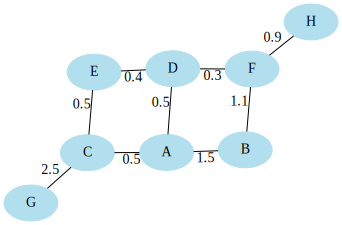

In [109]:
g = Graph()
g.num_nodes = 8
node = Node(0, 'A')
node.edges = [Edge(1, 0, 1.5), Edge(2, 0, 0.5), Edge(3, 0, 0.5)]
g.nodes.append(node)
node = Node(1, 'B')
node.edges = [Edge(0, 1, 1.5), Edge(5, 1, 1.1)]
g.nodes.append(node)
node = Node(2, 'C')
node.edges = [Edge(0, 2, 0.5), Edge(4, 2, 0.5), Edge(6, 2, 2.5)]
g.nodes.append(node)
node = Node(3, 'D')
node.edges = [Edge(0, 3, 0.5), Edge(4, 3, 0.4), Edge(5, 3, 0.3)]
g.nodes.append(node)
node = Node(4, 'E')
node.edges = [Edge(2, 4, 0.5), Edge(3, 4, 0.4)]
g.nodes.append(node)
node = Node(5, 'F')
node.edges = [Edge(1, 5, 1.1), Edge(3, 5, 0.3), Edge(7, 5, 0.9)]
g.nodes.append(node)
node = Node(6, 'G')
node.edges = [Edge(2, 6, 2.5)]
g.nodes.append(node)
node = Node(7, 'H')
node.edges = [Edge(5, 7, 0.9)]
g.nodes.append(node)

visualize_graph(g)

Now let's compute the list of shortest paths starting from node A to every other node using the Dijkstras algorithm and print that list. The last column indicates the index of the node before the current one in calculating the distance.

In [110]:
distances = g.Dijkstras(0)

df = pd.DataFrame(distances, columns=['Node', 'Distance', 'Last'])
print(df)

  Node  Distance  Last
0    A       0.0    -1
1    B       1.5     0
2    C       0.5     0
3    D       0.5     0
4    E       0.9     3
5    F       0.8     3
6    G       3.0     2
7    H       1.7     5


Now let's compute the minimum spanning tree for this graph using Prim's algorithm. To properly draw the minimum spanning tree edges (with red) we have to visualize the graph in directed mode (due to current limitations of the visualize function)

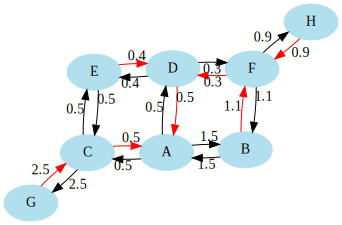

In [111]:
msp = g.Prims()
visualize_graph(g, True, msp)

Now let's define a directed acyclic graph and visualize it.

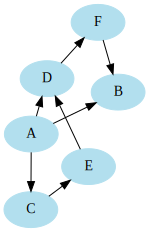

In [112]:
g = Graph()
g.num_nodes = 6
node = Node(0, 'A')
node.edges = [Edge(1, 0, None), Edge(2, 0, None), Edge(3, 0, None)]
g.nodes.append(node)
node = Node(1, 'B')
g.nodes.append(node)
node = Node(2, 'C')
node.edges = [Edge(4, 2, None)]
g.nodes.append(node)
node = Node(3, 'D')
node.edges = [Edge(5, 3, None)]
g.nodes.append(node)
node = Node(4, 'E')
node.edges = [Edge(3, 4, None)]
g.nodes.append(node)
node = Node(5, 'F')
node.edges = [Edge(1, 5, None)]
g.nodes.append(node)

visualize_graph(g, True)

Then calculate the topological sort for this graph using Kahn's algorithm and print the sorted list of nodes.

In [113]:
sorted = g.Kahns()
print('Topological sorted:', '->'.join([node.name for node in sorted]))

Topological sorted: A->C->E->D->F->B
